# Overview of this jupyter notebook

1. Loading extracted data with ts fresh
2. Hyperparameteroptimization with OC-SVM
3. Evaluate the optimized model
4. Saving results

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.svm import OneClassSVM
import pickle
import json
import random

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import os
import importlib
from library import etl_data as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
from library import autoencoder_helper as ah
from library import visualization_helper as vh
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(ch))
print(importlib.reload(ah))

<module 'library.etl_data' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\etl_data.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>
<module 'library.autoencoder_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\autoencoder_helper.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


In [5]:
!python -V

Python 3.10.6


# 1. Loading extracted data with ts fresh

In [6]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [7]:
feature_train = pd.read_pickle("feature_label/occ_feature_train_tsfresh_2.4.1.pkl")
feature_train.shape

(2150, 789)

In [8]:
feature_test = pd.read_pickle("feature_label/occ_feature_test_tsfresh_2.4.1.pkl")
feature_test.shape

(750, 789)

In [9]:
label_train = pd.read_pickle("feature_label/occ_label_train_tsfresh_v2.4.1.pkl")
label_train.shape

(2150,)

In [10]:
label_test = pd.read_pickle("feature_label/occ_label_test_tsfresh_v2.4.1.pkl")
label_test.shape

(750,)

In [11]:
relevance_table = pd.read_pickle("feature_label/occ_relevance_table_tsfresh_v2.4.1.pkl")
relevance_table

,feature,type,p_value,relevant
feature,,,,
torque__sum_values,torque__sum_values,real,0.0,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,0.0,True
torque__quantile__q_0.8,torque__quantile__q_0.8,real,0.0,True
torque__quantile__q_0.9,torque__quantile__q_0.9,real,0.0,True
torque__sample_entropy,torque__sample_entropy,real,0.0,True
...,...,...,...,...
torque__friedrich_coefficients__coeff_3__m_3__r_30,torque__friedrich_coefficients__coeff_3__m_3__...,constant,NaN,False
torque__max_langevin_fixed_point__m_3__r_30,torque__max_langevin_fixed_point__m_3__r_30,constant,NaN,False
torque__number_crossing_m__m_-1,torque__number_crossing_m__m_-1,constant,NaN,False


In [29]:
# tsfresh calculates the relevance of each feaeture with p-value

relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

506

In [14]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((2150, 506), (750, 506))

In [15]:
# using only curves from class 0 for x_train
# x_test contains 50 curves from each 15 classes

feat_train0 = feat_train[:700]
label_train0 = label_train[:700]
feat_train0.shape, label_train0.shape

((700, 506), (700,))

In [16]:
label_train0.sum()

0

In [31]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train0, label_train0, random_state=9)
x_test, y_test = shuffle(feat_test, label_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [48]:
y_train

242    0
81     0
651    0
426    0
121    0
      ..
614    0
377    0
332    0
428    0
191    0
Name: 0, Length: 700, dtype: int32

In [18]:
y_test

2403    1
2197    1
1232    1
2223    1
1254    1
       ..
839     1
2442    1
2638    1
1997    1
2135    1
Name: 0, Length: 750, dtype: int32

In [20]:
(y_train==0).sum(), (y_test==0).sum()

(700, 50)

In [21]:
x_train

,torque__sum_values,"torque__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""",torque__variation_coefficient,"torque__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""",torque__mean,"torque__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""",torque__index_mass_quantile__q_0.2,"torque__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","torque__fft_coefficient__attr_""abs""__coeff_0","torque__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",...,"torque__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","torque__fft_coefficient__attr_""real""__coeff_77","torque__fft_coefficient__attr_""imag""__coeff_89","torque__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","torque__fft_coefficient__attr_""real""__coeff_44","torque__fft_coefficient__attr_""real""__coeff_88","torque__fft_coefficient__attr_""abs""__coeff_1","torque__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)",torque__ratio_beyond_r_sigma__r_2.5,"torque__fft_coefficient__attr_""abs""__coeff_37"
242,61.71648,-0.029189,3.446381,-0.031457,0.067083,-0.027021,0.731522,-0.014055,61.71648,-0.027408,...,-0.003966,4.899863,4.916842,0.059043,7.719401,4.995866,56.910293,-0.013254,0.071739,5.479899
81,63.99232,-0.029185,3.357562,-0.027103,0.069557,-0.025413,0.739130,-0.011245,63.99232,-0.023271,...,0.014498,-0.121212,2.092657,0.016077,-7.048389,2.467033,55.214086,-0.000918,0.071739,5.520000
651,60.97280,-0.028875,3.523583,-0.029843,0.066275,-0.026867,0.732609,-0.013810,60.97280,-0.025784,...,0.000344,4.142382,4.867230,0.051834,7.674864,4.580142,55.748685,-0.006230,0.070652,5.549869
426,64.97792,-0.023703,3.248433,-0.019136,0.070628,-0.019508,0.727174,-0.006954,64.97792,-0.015973,...,0.012387,4.015739,2.913787,0.041306,7.203039,3.288151,55.416769,-0.002984,0.071739,5.551581
121,62.72000,-0.030255,3.500422,-0.026264,0.068174,-0.028049,0.732609,-0.014442,62.72000,-0.023936,...,0.004648,0.716409,0.782521,0.025433,6.651172,0.340255,57.360681,-0.002476,0.071739,6.842763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,58.89856,-0.031098,3.610815,-0.032472,0.064020,-0.031797,0.739130,-0.018217,58.89856,-0.034836,...,-0.005461,-5.227966,-5.587369,0.043552,0.584785,-5.648508,56.246083,-0.005099,0.071739,5.728816
377,68.62016,-0.014918,3.128814,-0.006478,0.074587,-0.009298,0.715217,0.001618,68.62016,-0.004345,...,0.026142,5.386430,2.728740,0.027974,-7.350428,3.417582,55.002547,-0.001635,0.071739,5.817921
332,60.82944,-0.021695,3.443501,-0.015196,0.066119,-0.019004,0.710870,-0.008242,60.82944,-0.015236,...,-0.005243,-4.940776,2.433030,0.054931,6.271923,1.439581,55.766495,-0.007868,0.071739,5.926031
428,61.99424,-0.031048,3.385509,-0.033691,0.067385,-0.028445,0.742391,-0.014101,61.99424,-0.028938,...,0.013190,3.355877,4.684995,0.025513,-7.233834,5.173554,55.343634,-0.001409,0.071739,4.928125


In [32]:
x_test

,torque__sum_values,"torque__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""",torque__variation_coefficient,"torque__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""",torque__mean,"torque__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""",torque__index_mass_quantile__q_0.2,"torque__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","torque__fft_coefficient__attr_""abs""__coeff_0","torque__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",...,"torque__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","torque__fft_coefficient__attr_""real""__coeff_77","torque__fft_coefficient__attr_""imag""__coeff_89","torque__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","torque__fft_coefficient__attr_""real""__coeff_44","torque__fft_coefficient__attr_""real""__coeff_88","torque__fft_coefficient__attr_""abs""__coeff_1","torque__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)",torque__ratio_beyond_r_sigma__r_2.5,"torque__fft_coefficient__attr_""abs""__coeff_37"
2403,172.06784,0.090391,1.244409,0.127240,0.187030,0.103595,0.390217,0.123530,172.06784,0.117947,...,0.004754,-4.808003,-0.847310,0.056145,3.998218,-0.331902,73.086658,-0.009135,0.067391,6.395115
2197,131.93600,0.025980,1.678884,0.040889,0.143409,0.033227,0.498913,0.051306,131.93600,0.039420,...,0.000889,-2.600325,2.082847,0.070756,-5.411458,1.674357,90.383155,-0.012434,0.068478,4.182564
1232,77.76832,0.038546,2.713042,0.068645,0.084531,0.049233,0.516304,0.057500,77.76832,0.060129,...,-0.002683,1.132816,-4.550428,0.074260,-1.065323,-4.108229,54.157167,-0.012720,0.072826,6.820842
2223,86.43264,-0.024649,2.427577,-0.009243,0.093949,-0.019912,0.430435,-0.005035,86.43264,-0.013477,...,0.005435,0.976022,-0.725161,0.048132,-1.166057,-0.726686,62.709536,-0.006576,0.075000,2.950221
1254,82.79488,0.050661,2.603434,0.079562,0.089994,0.060958,0.436957,0.069035,82.79488,0.070924,...,-0.014737,3.881933,-5.285191,0.078913,-4.147420,-2.998213,52.786357,-0.016024,0.071739,7.251850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,134.81216,0.060422,1.508050,0.092591,0.146535,0.071070,0.240217,0.085113,134.81216,0.077343,...,-0.005972,2.417075,0.977185,0.028362,7.053530,2.502437,43.205862,-0.024220,0.072826,4.305571
2442,190.40448,0.096919,1.128310,0.168003,0.206961,0.123738,0.356522,0.144803,190.40448,0.149850,...,0.012837,-3.545690,-4.226639,0.011227,-1.493901,-3.983432,80.737487,-0.015312,0.040217,3.813307
2638,209.01440,0.148967,1.292183,0.207217,0.227190,0.169218,0.404348,0.186351,209.01440,0.189202,...,0.003885,2.580960,-0.799619,0.035997,5.112242,-2.022267,146.072945,-0.003224,0.007609,7.495010
1997,87.60640,0.037402,2.265254,0.055991,0.095224,0.045077,0.470652,0.054247,87.60640,0.052761,...,-0.001958,0.846764,0.832587,0.027430,0.636923,0.825756,56.287723,-0.002648,0.076087,2.881271


# 2 Hyperparameteroptimization with OC-SVM

In [44]:
def calc_metrics(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1][1]
    fn = cm[1][0]
    fp = cm[0][1]
    tn = cm[0][0]

    # negative predictive value
    npv = tn/(tn+fn) 
    
    # true negative rate
    tnr = tn/(tn+fp)
    
    return npv, tnr

In [65]:
def filter_fetures(amount_feat, train, test, relevance_df):
    
    relevant_feature = list(relevance_df.iloc[:amount_feat].feature)
    
    xtrain = train[relevant_feature]
    xtest = test[relevant_feature]
    
    print(xtrain.shape, xtest.shape)
    return xtrain, xtest

In [175]:
from itertools import product

kernel = ['rbf', 'sigmoid']
coef0 = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
gamma = ['scale','auto', 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
nu = [0.1, 0.3, 0.5]

paramcom = product(kernel, coef0, gamma, nu)

In [176]:
result_hyperopt = {"feature_number":[], "kernel":[], "coef0":[], "gamma":[], "nu":[],
                   "mean_npv":[], "mean_tnr":[], "mean_acc":[]}

In [177]:
kf = KFold(n_splits=5)

for i, com in enumerate(paramcom):
    print(f"start {i}th combination: {com}")
    
    for r in range(20, len(relevance_table), 50):  # also the number of features for the training can be optimized

        Xtrain, Xtest = filter_fetures(amount_feat=r, train=x_train, test=x_test, 
                                       relevance_df=relevance_table)
        Xtrain = Xtrain.values
        Ytrain = np.zeros(Xtrain.shape[0])
        print(Xtrain.shape, Ytrain.shape)
          
        npv_list=[]
        tnr_list=[]
        acc_list=[]

        for j, (train_index, val_index) in enumerate(kf.split(Xtrain)):
            print(f"fold {j} start")
            xtrain, xval = Xtrain[train_index], Xtrain[val_index]
            ytrain, yval = Ytrain[train_index], Ytrain[val_index]

            model = OneClassSVM(kernel=com[0], coef0=com[1], gamma=com[2], nu=com[3])
            model.fit(xtrain)
            ypred = model.predict(xval)
            ypred[ypred==1] = 0
            ypred[ypred==-1] = 1

            npv, tnr = ch.calc_metrics_occ(yval, ypred)
            npv_list.append(npv)
            tnr_list.append(tnr)
            acc_list.append(accuracy_score(yval, ypred))
            print(f"fold {j} end")
        
        result_hyperopt["feature_number"].append(r)
        result_hyperopt["kernel"].append(com[0])
        result_hyperopt["coef0"].append(com[1])
        result_hyperopt["gamma"].append(com[2])
        result_hyperopt["nu"].append(com[3])
        result_hyperopt["mean_npv"].append(np.mean(npv_list))
        result_hyperopt["mean_tnr"].append(np.mean(tnr_list))
        result_hyperopt["mean_acc"].append(np.mean(acc_list))

        print(len(npv_list), np.mean(npv_list), np.mean(tnr_list), np.mean(acc_list))    
        print(f"end {i}th combination: {com}")

start 0th combination: ('rbf', 0.001, 'scale', 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8985714285714286 0.8985714285714286
end 0th combination: ('rbf', 0.001, 'scale', 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.9 0.9
end 0th combination: ('rbf', 0.001, 'scale', 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8985714285714286 0.8985714285714286
end 0th combination: ('rbf', 0.001, 'scale', 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.9014285714285715 0.9014285714285715
end 0th combinatio

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.1842857142857143 0.1842857142857143
end 3th combination: ('rbf', 0.001, 'auto', 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.04285714285714286 0.04285714285714286
end 3th combination: ('rbf', 0.001, 'auto', 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.032857142857142856 0.032857142857142856
end 3th combination: ('rbf', 0.001, 'auto', 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.06428571428571428 0.06428571428571428
end 3th combination: ('rbf', 0.001, 'auto', 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.25428571428571434 0.25428571428571434
end 6th combination: ('rbf', 0.001, 0.001, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 6th combination: ('rbf', 0.001, 0.001, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 6th combination: ('rbf', 0.001, 0.001, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 6th combination: ('rbf', 0.001, 0.001, 0.1)
start 7th combination: ('rbf', 0.001, 0.001, 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 en

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5614285714285715 0.5614285714285715
end 10th combination: ('rbf', 0.001, 0.01, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.11714285714285713 0.11714285714285713
end 10th combination: ('rbf', 0.001, 0.01, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.004285714285714286 0.004285714285714286
end 10th combination: ('rbf', 0.001, 0.01, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 10th combination: ('rbf', 0.001, 0.01, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 

fold 4 end
5 nan 0.0 0.0
end 13th combination: ('rbf', 0.001, 0.05, 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 13th combination: ('rbf', 0.001, 0.05, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 13th combination: ('rbf', 0.001, 0.05, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 13th combination: ('rbf', 0.001, 0.05, 0.3)
start 14th combination: ('rbf', 0.001, 0.05, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 14th combination: ('rbf', 0.001, 0.0

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 17th combination: ('rbf', 0.001, 0.1, 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 17th combination: ('rbf', 0.001, 0.1, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 17th combination: ('rbf', 0.001, 0.1, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 17th combination: ('rbf', 0.001, 0.1, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 17th combination: ('rbf', 0.001, 0.1, 0.5)
(700, 370) (750, 370

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 20th combination: ('rbf', 0.001, 0.2, 0.5)
start 21th combination: ('rbf', 0.001, 0.5, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8642857142857142 0.8642857142857142
end 21th combination: ('rbf', 0.001, 0.5, 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 21th combination: ('rbf', 0.001, 0.5, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 21th combination: ('rbf', 0.001, 0.5, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 s

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 24th combination: ('rbf', 0.001, 0.9, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 24th combination: ('rbf', 0.001, 0.9, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 24th combination: ('rbf', 0.001, 0.9, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 24th combination: ('rbf', 0.001, 0.9, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 24th combinatio

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6957142857142858 0.6957142857142858
end 28th combination: ('rbf', 0.01, 'scale', 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.7014285714285715 0.7014285714285715
end 28th combination: ('rbf', 0.01, 'scale', 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6985714285714286 0.6985714285714286
end 28th combination: ('rbf', 0.01, 'scale', 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6985714285714286 0.6985714285714286
end 28th combination: ('rbf', 0.01, 'scale', 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 e

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.032857142857142856 0.032857142857142856
end 31th combination: ('rbf', 0.01, 'auto', 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.0657142857142857 0.0657142857142857
end 31th combination: ('rbf', 0.01, 'auto', 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.002857142857142857 0.002857142857142857
end 31th combination: ('rbf', 0.01, 'auto', 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 31th combination: ('rbf', 0.01, 'auto', 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 34th combination: ('rbf', 0.01, 0.001, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 34th combination: ('rbf', 0.01, 0.001, 0.3)
start 35th combination: ('rbf', 0.01, 0.001, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5014285714285714 0.5014285714285714
end 35th combination: ('rbf', 0.01, 0.001, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.4957142857142857 0.4957142857142857
end 35th combination: ('rbf', 0.01, 0.001, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 e

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.004285714285714286 0.004285714285714286
end 38th combination: ('rbf', 0.01, 0.01, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 38th combination: ('rbf', 0.01, 0.01, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 38th combination: ('rbf', 0.01, 0.01, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 38th combination: ('rbf', 0.01, 0.01, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 41th combination: ('rbf', 0.01, 0.05, 0.5)
start 42th combination: ('rbf', 0.01, 0.1, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8800000000000001 0.8800000000000001
end 42th combination: ('rbf', 0.01, 0.1, 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.011428571428571429 0.011428571428571429
end 42th combination: ('rbf', 0.01, 0.1, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 42th combination: ('rbf', 0.01, 0.1, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fo

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 45th combination: ('rbf', 0.01, 0.2, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 45th combination: ('rbf', 0.01, 0.2, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 45th combination: ('rbf', 0.01, 0.2, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 45th combination: ('rbf', 0.01, 0.2, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 45th combination: (

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 49th combination: ('rbf', 0.01, 0.5, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 49th combination: ('rbf', 0.01, 0.5, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 49th combination: ('rbf', 0.01, 0.5, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 49th combination: ('rbf', 0.01, 0.5, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 49th combination: ('rbf', 0.01, 0.5, 0.3)
(700, 320) (750, 320)
(70

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 52th combination: ('rbf', 0.01, 0.9, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 52th combination: ('rbf', 0.01, 0.9, 0.3)
start 53th combination: ('rbf', 0.01, 0.9, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.48857142857142855 0.48857142857142855
end 53th combination: ('rbf', 0.01, 0.9, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 53th combination: ('rbf', 0.01, 0.9, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 star

fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5014285714285714 0.5014285714285714
end 56th combination: ('rbf', 0.05, 'scale', 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.49857142857142855 0.49857142857142855
end 56th combination: ('rbf', 0.05, 'scale', 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5014285714285714 0.5014285714285714
end 56th combination: ('rbf', 0.05, 'scale', 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 56th combination: ('rbf', 0.05, 'scale', 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
f

fold 3 end
fold 4 start
fold 4 end
5 1.0 0.0657142857142857 0.0657142857142857
end 59th combination: ('rbf', 0.05, 'auto', 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.002857142857142857 0.002857142857142857
end 59th combination: ('rbf', 0.05, 'auto', 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 59th combination: ('rbf', 0.05, 'auto', 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 59th combination: ('rbf', 0.05, 'auto', 0.5)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 62th combination: ('rbf', 0.05, 0.001, 0.5)
start 63th combination: ('rbf', 0.05, 0.01, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8928571428571429 0.8928571428571429
end 63th combination: ('rbf', 0.05, 0.01, 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.59 0.59
end 63th combination: ('rbf', 0.05, 0.01, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.11714285714285713 0.11714285714285713
end 63th combination: ('rbf', 0.05, 0.01, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 e

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 66th combination: ('rbf', 0.05, 0.05, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 66th combination: ('rbf', 0.05, 0.05, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 66th combination: ('rbf', 0.05, 0.05, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 66th combination: ('rbf', 0.05, 0.05, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 66th combination: ('rbf', 0.05, 0.05, 0

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.7028571428571428 0.7028571428571428
end 70th combination: ('rbf', 0.05, 0.1, 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.011428571428571429 0.011428571428571429
end 70th combination: ('rbf', 0.05, 0.1, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 70th combination: ('rbf', 0.05, 0.1, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 70th combination: ('rbf', 0.05, 0.1, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end


fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 73th combination: ('rbf', 0.05, 0.2, 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 73th combination: ('rbf', 0.05, 0.2, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 73th combination: ('rbf', 0.05, 0.2, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 73th combination: ('rbf', 0.05, 0.2, 0.3)
start 74th combination: ('rbf', 0.05, 0.2, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fol

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 77th combination: ('rbf', 0.05, 0.5, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 77th combination: ('rbf', 0.05, 0.5, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 77th combination: ('rbf', 0.05, 0.5, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 77th combination: ('rbf', 0.05, 0.5, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 80th combination: ('rbf', 0.05, 0.9, 0.5)
start 81th combination: ('rbf', 0.1, 'scale', 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8985714285714286 0.8985714285714286
end 81th combination: ('rbf', 0.1, 'scale', 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.9 0.9
end 81th combination: ('rbf', 0.1, 'scale', 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8985714285714286 0.8985714285714286
end 81th combination: ('rbf', 0.1, 'scale', 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3

fold 3 end
fold 4 start
fold 4 end
5 1.0 0.1842857142857143 0.1842857142857143
end 84th combination: ('rbf', 0.1, 'auto', 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.04285714285714286 0.04285714285714286
end 84th combination: ('rbf', 0.1, 'auto', 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.032857142857142856 0.032857142857142856
end 84th combination: ('rbf', 0.1, 'auto', 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.06428571428571428 0.06428571428571428
end 84th combination: ('rbf', 0.1, 'auto', 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 e

fold 3 end
fold 4 start
fold 4 end
5 1.0 0.25428571428571434 0.25428571428571434
end 87th combination: ('rbf', 0.1, 0.001, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 87th combination: ('rbf', 0.1, 0.001, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 87th combination: ('rbf', 0.1, 0.001, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 87th combination: ('rbf', 0.1, 0.001, 0.1)
start 88th combination: ('rbf', 0.1, 0.001, 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.11714285714285713 0.11714285714285713
end 91th combination: ('rbf', 0.1, 0.01, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.004285714285714286 0.004285714285714286
end 91th combination: ('rbf', 0.1, 0.01, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 91th combination: ('rbf', 0.1, 0.01, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 91th combination: ('rbf', 0.1, 0.01, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 94th combination: ('rbf', 0.1, 0.05, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 94th combination: ('rbf', 0.1, 0.05, 0.3)
start 95th combination: ('rbf', 0.1, 0.05, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 95th combination: ('rbf', 0.1, 0.05, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.10428571428571429 0.10428571428571429
end 95th combination: ('rbf', 0.1, 0.05, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 star

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 98th combination: ('rbf', 0.1, 0.1, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 98th combination: ('rbf', 0.1, 0.1, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 98th combination: ('rbf', 0.1, 0.1, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 98th combination: ('rbf', 0.1, 0.1, 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 102th combination: ('rbf', 0.1, 0.5, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 102th combination: ('rbf', 0.1, 0.5, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 102th combination: ('rbf', 0.1, 0.5, 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 102th combination: ('rbf', 0.1, 0.5, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 102th combination: 

fold 4 end
5 nan 0.0 0.0
end 105th combination: ('rbf', 0.1, 0.9, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 105th combination: ('rbf', 0.1, 0.9, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 105th combination: ('rbf', 0.1, 0.9, 0.1)
start 106th combination: ('rbf', 0.1, 0.9, 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6685714285714287 0.6685714285714287
end 106th combination: ('rbf', 0.1, 0.9, 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 106th combination: 

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.7014285714285715 0.7014285714285715
end 109th combination: ('rbf', 0.2, 'scale', 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6985714285714286 0.6985714285714286
end 109th combination: ('rbf', 0.2, 'scale', 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6985714285714286 0.6985714285714286
end 109th combination: ('rbf', 0.2, 'scale', 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6985714285714286 0.6985714285714286
end 109th combination: ('rbf', 0.2, 'scale', 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 e

fold 3 end
fold 4 start
fold 4 end
5 1.0 0.0657142857142857 0.0657142857142857
end 112th combination: ('rbf', 0.2, 'auto', 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.002857142857142857 0.002857142857142857
end 112th combination: ('rbf', 0.2, 'auto', 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 112th combination: ('rbf', 0.2, 'auto', 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 112th combination: ('rbf', 0.2, 'auto', 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 115th combination: ('rbf', 0.2, 0.001, 0.3)
start 116th combination: ('rbf', 0.2, 0.001, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5014285714285714 0.5014285714285714
end 116th combination: ('rbf', 0.2, 0.001, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.4957142857142857 0.4957142857142857
end 116th combination: ('rbf', 0.2, 0.001, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.47000000000000003 0.47000000000000003
end 116th combination: ('rbf', 0.2, 0.001, 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start


fold 3 end
fold 4 start
fold 4 end
5 nan 0.004285714285714286 0.004285714285714286
end 119th combination: ('rbf', 0.2, 0.01, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 119th combination: ('rbf', 0.2, 0.01, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 119th combination: ('rbf', 0.2, 0.01, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 119th combination: ('rbf', 0.2, 0.01, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 119th combination: ('rbf', 0.

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 122th combination: ('rbf', 0.2, 0.05, 0.5)
start 123th combination: ('rbf', 0.2, 0.1, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8800000000000001 0.8800000000000001
end 123th combination: ('rbf', 0.2, 0.1, 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.011428571428571429 0.011428571428571429
end 123th combination: ('rbf', 0.2, 0.1, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 123th combination: ('rbf', 0.2, 0.1, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fo

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 126th combination: ('rbf', 0.2, 0.2, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 126th combination: ('rbf', 0.2, 0.2, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 126th combination: ('rbf', 0.2, 0.2, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 126th combination: ('rbf', 0.2, 0.2, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 130th combination: ('rbf', 0.2, 0.5, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 130th combination: ('rbf', 0.2, 0.5, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 130th combination: ('rbf', 0.2, 0.5, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 130th combination: ('rbf', 0.2, 0.5, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 130th combination: ('rbf', 0.2, 0.5, 0.3)
(700, 320) (750, 320)
(70

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 133th combination: ('rbf', 0.2, 0.9, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 133th combination: ('rbf', 0.2, 0.9, 0.3)
start 134th combination: ('rbf', 0.2, 0.9, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.48857142857142855 0.48857142857142855
end 134th combination: ('rbf', 0.2, 0.9, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 134th combination: ('rbf', 0.2, 0.9, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 star

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5014285714285714 0.5014285714285714
end 137th combination: ('rbf', 0.5, 'scale', 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.49857142857142855 0.49857142857142855
end 137th combination: ('rbf', 0.5, 'scale', 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5014285714285714 0.5014285714285714
end 137th combination: ('rbf', 0.5, 'scale', 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 137th combination: ('rbf', 0.5, 'scale', 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
f

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.0657142857142857 0.0657142857142857
end 140th combination: ('rbf', 0.5, 'auto', 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.002857142857142857 0.002857142857142857
end 140th combination: ('rbf', 0.5, 'auto', 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 140th combination: ('rbf', 0.5, 'auto', 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 140th combination: ('rbf', 0.5, 'auto', 0.5)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 st

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 143th combination: ('rbf', 0.5, 0.001, 0.5)
start 144th combination: ('rbf', 0.5, 0.01, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8928571428571429 0.8928571428571429
end 144th combination: ('rbf', 0.5, 0.01, 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.59 0.59
end 144th combination: ('rbf', 0.5, 0.01, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.11714285714285713 0.11714285714285713
end 144th combination: ('rbf', 0.5, 0.01, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 e

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 147th combination: ('rbf', 0.5, 0.05, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 147th combination: ('rbf', 0.5, 0.05, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 147th combination: ('rbf', 0.5, 0.05, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 147th combination: ('rbf', 0.5, 0.05, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 147th combinati

fold 4 end
5 1.0 0.7028571428571428 0.7028571428571428
end 151th combination: ('rbf', 0.5, 0.1, 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.011428571428571429 0.011428571428571429
end 151th combination: ('rbf', 0.5, 0.1, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 151th combination: ('rbf', 0.5, 0.1, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 151th combination: ('rbf', 0.5, 0.1, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 151th combination: ('rbf', 0.5

fold 4 end
5 nan 0.0 0.0
end 154th combination: ('rbf', 0.5, 0.2, 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 154th combination: ('rbf', 0.5, 0.2, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 154th combination: ('rbf', 0.5, 0.2, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 154th combination: ('rbf', 0.5, 0.2, 0.3)
start 155th combination: ('rbf', 0.5, 0.2, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.47857142857142854 0.47857142857142854
end 155th combinat

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 158th combination: ('rbf', 0.5, 0.5, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 158th combination: ('rbf', 0.5, 0.5, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 158th combination: ('rbf', 0.5, 0.5, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 158th combination: ('rbf', 0.5, 0.5, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 158th combination: ('rbf', 0.5, 0.5, 0.5)
(

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8985714285714286 0.8985714285714286
end 162th combination: ('rbf', 1.0, 'scale', 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.9014285714285715 0.9014285714285715
end 162th combination: ('rbf', 1.0, 'scale', 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.9014285714285715 0.9014285714285715
end 162th combination: ('rbf', 1.0, 'scale', 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.9 0.9
end 162th combination: ('rbf', 1.0, 'scale', 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fol

fold 3 end
fold 4 start
fold 4 end
5 1.0 0.032857142857142856 0.032857142857142856
end 165th combination: ('rbf', 1.0, 'auto', 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.06428571428571428 0.06428571428571428
end 165th combination: ('rbf', 1.0, 'auto', 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.002857142857142857 0.002857142857142857
end 165th combination: ('rbf', 1.0, 'auto', 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 165th combination: ('rbf', 1.0, 'auto', 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 e

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 168th combination: ('rbf', 1.0, 0.001, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 168th combination: ('rbf', 1.0, 0.001, 0.1)
start 169th combination: ('rbf', 1.0, 0.001, 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6971428571428571 0.6971428571428571
end 169th combination: ('rbf', 1.0, 0.001, 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6857142857142857 0.6857142857142857
end 169th combination: ('rbf', 1.0, 0.001, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 e

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.11714285714285713 0.11714285714285713
end 172th combination: ('rbf', 1.0, 0.01, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.004285714285714286 0.004285714285714286
end 172th combination: ('rbf', 1.0, 0.01, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 172th combination: ('rbf', 1.0, 0.01, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 172th combination: ('rbf', 1.0, 0.01, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fo

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 175th combination: ('rbf', 1.0, 0.05, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 175th combination: ('rbf', 1.0, 0.05, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 175th combination: ('rbf', 1.0, 0.05, 0.3)
start 176th combination: ('rbf', 1.0, 0.05, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 176th combination: ('rbf', 1.0, 0.05, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.10428571428571429 0.1042857142

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 179th combination: ('rbf', 1.0, 0.1, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 179th combination: ('rbf', 1.0, 0.1, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 179th combination: ('rbf', 1.0, 0.1, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 179th combination: ('rbf', 1.0, 0.1, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 179th combination: ('rbf', 1.0, 0.1, 0.5)
(700, 420) (750, 420)
(70

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 183th combination: ('rbf', 1.0, 0.5, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 183th combination: ('rbf', 1.0, 0.5, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 183th combination: ('rbf', 1.0, 0.5, 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 183th combination: ('rbf', 1.0, 0.5, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0

fold 4 end
5 nan 0.0 0.0
end 186th combination: ('rbf', 1.0, 0.9, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 186th combination: ('rbf', 1.0, 0.9, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 186th combination: ('rbf', 1.0, 0.9, 0.1)
start 187th combination: ('rbf', 1.0, 0.9, 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6685714285714287 0.6685714285714287
end 187th combination: ('rbf', 1.0, 0.9, 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 187th combination: 

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6985714285714285 0.6985714285714285
end 190th combination: ('sigmoid', 0.001, 'scale', 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.7 0.7
end 190th combination: ('sigmoid', 0.001, 'scale', 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.7 0.7
end 190th combination: ('sigmoid', 0.001, 'scale', 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6928571428571428 0.6928571428571428
end 190th combination: ('sigmoid', 0.001, 'scale', 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 st

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 193th combination: ('sigmoid', 0.001, 'auto', 0.3)
start 194th combination: ('sigmoid', 0.001, 'auto', 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 194th combination: ('sigmoid', 0.001, 'auto', 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 194th combination: ('sigmoid', 0.001, 'auto', 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 194th combination: ('sigmoid', 0.001, 'auto', 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 en

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 197th combination: ('sigmoid', 0.001, 0.001, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 197th combination: ('sigmoid', 0.001, 0.001, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 197th combination: ('sigmoid', 0.001, 0.001, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 197th combination: ('sigmoid', 0.001, 0.001, 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 197th combination: ('sigmoid', 0.00

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 201th combination: ('sigmoid', 0.001, 0.05, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 201th combination: ('sigmoid', 0.001, 0.05, 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 201th combination: ('sigmoid', 0.001, 0.05, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 201th combination: ('sigmoid', 0.001, 0.05, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 201th combinati

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 205th combination: ('sigmoid', 0.001, 0.1, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 205th combination: ('sigmoid', 0.001, 0.1, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 205th combination: ('sigmoid', 0.001, 0.1, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 205th combination: ('sigmoid', 0.001, 0.1, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 205th combination: ('sigmoid', 0.001, 0.1, 

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 208th combination: ('sigmoid', 0.001, 0.2, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 208th combination: ('sigmoid', 0.001, 0.2, 0.3)
start 209th combination: ('sigmoid', 0.001, 0.2, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 209th combination: ('sigmoid', 0.001, 0.2, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 209th combination: ('sigmoid', 0.001, 0.2, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 212th combination: ('sigmoid', 0.001, 0.5, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 212th combination: ('sigmoid', 0.001, 0.5, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 212th combination: ('sigmoid', 0.001, 0.5, 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 212th combination: ('sigmoid', 0.001, 0.5, 0.5)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 212th combination: ('sigmoid', 0.001, 0.5, 

fold 3 end
fold 4 start
fold 4 end
5 1.0 0.9014285714285715 0.9014285714285715
end 216th combination: ('sigmoid', 0.01, 'scale', 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.9 0.9
end 216th combination: ('sigmoid', 0.01, 'scale', 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8971428571428571 0.8971428571428571
end 216th combination: ('sigmoid', 0.01, 'scale', 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8957142857142857 0.8957142857142857
end 216th combination: ('sigmoid', 0.01, 'scale', 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 219th combination: ('sigmoid', 0.01, 'auto', 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 219th combination: ('sigmoid', 0.01, 'auto', 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 219th combination: ('sigmoid', 0.01, 'auto', 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 219th combination: ('sigmoid', 0.01, 'auto', 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 219th combination: ('sigmoid', 0.01

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 223th combination: ('sigmoid', 0.01, 0.001, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 223th combination: ('sigmoid', 0.01, 0.001, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 223th combination: ('sigmoid', 0.01, 0.001, 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 223th combination: ('sigmoid', 0.01, 0.001, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 223th combination: ('sigmoid', 0.01, 0.

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 227th combination: ('sigmoid', 0.01, 0.01, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 227th combination: ('sigmoid', 0.01, 0.01, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 227th combination: ('sigmoid', 0.01, 0.01, 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 227th combination: ('sigmoid', 0.01, 0.01, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 227th combination: ('s

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 230th combination: ('sigmoid', 0.01, 0.05, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 230th combination: ('sigmoid', 0.01, 0.05, 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 230th combination: ('sigmoid', 0.01, 0.05, 0.5)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 230th combination: ('sigmoid', 0.01, 0.05, 0.5)
start 231th combination: ('sigmoid', 0.01, 0.1, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 star

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 234th combination: ('sigmoid', 0.01, 0.2, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 234th combination: ('sigmoid', 0.01, 0.2, 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 234th combination: ('sigmoid', 0.01, 0.2, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 234th combination: ('sigmoid', 0.01, 0.2, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 238th combination: ('sigmoid', 0.01, 0.5, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 238th combination: ('sigmoid', 0.01, 0.5, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 238th combination: ('sigmoid', 0.01, 0.5, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 238th combination: ('sigmoid', 0.01, 0.5, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 241th combination: ('sigmoid', 0.01, 0.9, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 241th combination: ('sigmoid', 0.01, 0.9, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 241th combination: ('sigmoid', 0.01, 0.9, 0.3)
start 242th combination: ('sigmoid', 0.01, 0.9, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 242th combination: ('sigmoid', 0.01, 0.9, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 

fold 4 end
5 1.0 0.5014285714285714 0.5014285714285714
end 245th combination: ('sigmoid', 0.05, 'scale', 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5028571428571429 0.5028571428571429
end 245th combination: ('sigmoid', 0.05, 'scale', 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 245th combination: ('sigmoid', 0.05, 'scale', 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 245th combination: ('sigmoid', 0.05, 'scale', 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5

fold 4 end
5 nan 0.0 0.0
end 248th combination: ('sigmoid', 0.05, 'auto', 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 248th combination: ('sigmoid', 0.05, 'auto', 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 248th combination: ('sigmoid', 0.05, 'auto', 0.5)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 248th combination: ('sigmoid', 0.05, 'auto', 0.5)
start 249th combination: ('sigmoid', 0.05, 0.001, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 249th c

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 252th combination: ('sigmoid', 0.05, 0.01, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 252th combination: ('sigmoid', 0.05, 0.01, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 252th combination: ('sigmoid', 0.05, 0.01, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 252th combination: ('sigmoid', 0.05, 0.01, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 252th combination: 

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 256th combination: ('sigmoid', 0.05, 0.05, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 256th combination: ('sigmoid', 0.05, 0.05, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 256th combination: ('sigmoid', 0.05, 0.05, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 256th combination: ('sigmoid', 0.05, 0.05, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start


fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 259th combination: ('sigmoid', 0.05, 0.1, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 259th combination: ('sigmoid', 0.05, 0.1, 0.3)
start 260th combination: ('sigmoid', 0.05, 0.1, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 260th combination: ('sigmoid', 0.05, 0.1, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 260th combination: ('sigmoid', 0.05, 0.1, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 263th combination: ('sigmoid', 0.05, 0.2, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 263th combination: ('sigmoid', 0.05, 0.2, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 263th combination: ('sigmoid', 0.05, 0.2, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 263th combination: ('sigmoid', 0.05, 0.2, 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 267th combination: ('sigmoid', 0.05, 0.9, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 267th combination: ('sigmoid', 0.05, 0.9, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 267th combination: ('sigmoid', 0.05, 0.9, 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 267th combination: ('sigmoid', 0.05, 0.9, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end

fold 4 end
5 1.0 0.8985714285714288 0.8985714285714288
end 270th combination: ('sigmoid', 0.1, 'scale', 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8985714285714288 0.8985714285714288
end 270th combination: ('sigmoid', 0.1, 'scale', 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8985714285714288 0.8985714285714288
end 270th combination: ('sigmoid', 0.1, 'scale', 0.1)
start 271th combination: ('sigmoid', 0.1, 'scale', 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.7014285714285714 0.7014285714285714
end 271th combination: ('sigmoid', 0.1, 'scale', 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fol

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 274th combination: ('sigmoid', 0.1, 'auto', 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 274th combination: ('sigmoid', 0.1, 'auto', 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 274th combination: ('sigmoid', 0.1, 'auto', 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 274th combination: ('sigmoid', 0.1, 'auto', 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 274th combinati

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 277th combination: ('sigmoid', 0.1, 0.001, 0.3)
start 278th combination: ('sigmoid', 0.1, 0.001, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 278th combination: ('sigmoid', 0.1, 0.001, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 278th combination: ('sigmoid', 0.1, 0.001, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 278th combination: ('sigmoid', 0.1, 0.001, 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start


fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 281th combination: ('sigmoid', 0.1, 0.01, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 281th combination: ('sigmoid', 0.1, 0.01, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 281th combination: ('sigmoid', 0.1, 0.01, 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 281th combination: ('sigmoid', 0.1, 0.01, 0.5)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 285th combination: ('sigmoid', 0.1, 0.1, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 285th combination: ('sigmoid', 0.1, 0.1, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 285th combination: ('sigmoid', 0.1, 0.1, 0.1)
start 286th combination: ('sigmoid', 0.1, 0.1, 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 286th combination: ('sigmoid', 0.1, 0.1, 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 286th

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 289th combination: ('sigmoid', 0.1, 0.2, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 289th combination: ('sigmoid', 0.1, 0.2, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 289th combination: ('sigmoid', 0.1, 0.2, 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 289th combination: ('sigmoid', 0.1, 0.2, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 289th combination: ('sigmoid', 0.1, 0.2, 0.3)
(700,

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 293th combination: ('sigmoid', 0.1, 0.5, 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 293th combination: ('sigmoid', 0.1, 0.5, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 293th combination: ('sigmoid', 0.1, 0.5, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 293th combination: ('sigmoid', 0.1, 0.5, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 293

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 296th combination: ('sigmoid', 0.1, 0.9, 0.5)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 296th combination: ('sigmoid', 0.1, 0.9, 0.5)
start 297th combination: ('sigmoid', 0.2, 'scale', 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8971428571428571 0.8971428571428571
end 297th combination: ('sigmoid', 0.2, 'scale', 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.8985714285714286 0.8985714285714286
end 297th combination: ('sigmoid', 0.2, 'scale', 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end

fold 4 end
5 nan 0.0 0.0
end 300th combination: ('sigmoid', 0.2, 'auto', 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 300th combination: ('sigmoid', 0.2, 'auto', 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 300th combination: ('sigmoid', 0.2, 'auto', 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 300th combination: ('sigmoid', 0.2, 'auto', 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 300th combination: ('sigmoid', 0.2, 'auto', 0.1)
(700, 420) (75

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 304th combination: ('sigmoid', 0.2, 0.001, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 304th combination: ('sigmoid', 0.2, 0.001, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 304th combination: ('sigmoid', 0.2, 0.001, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 304th combination: ('sigmoid', 0.2, 0.001, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start


fold 4 end
5 nan 0.0 0.0
end 307th combination: ('sigmoid', 0.2, 0.01, 0.3)
start 308th combination: ('sigmoid', 0.2, 0.01, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 308th combination: ('sigmoid', 0.2, 0.01, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 308th combination: ('sigmoid', 0.2, 0.01, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 308th combination: ('sigmoid', 0.2, 0.01, 0.5)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 308th combination: ('sig

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 311th combination: ('sigmoid', 0.2, 0.05, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 311th combination: ('sigmoid', 0.2, 0.05, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 311th combination: ('sigmoid', 0.2, 0.05, 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 311th combination: ('sigmoid', 0.2, 0.05, 0.5)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 311th combination: ('sigmoid', 0.2, 0.05, 0.5)


fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 315th combination: ('sigmoid', 0.2, 0.2, 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 315th combination: ('sigmoid', 0.2, 0.2, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 315th combination: ('sigmoid', 0.2, 0.2, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 315th combination: ('sigmoid', 0.2, 0.2, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 315th combination: ('sigmoi

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 319th combination: ('sigmoid', 0.2, 0.5, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 319th combination: ('sigmoid', 0.2, 0.5, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 319th combination: ('sigmoid', 0.2, 0.5, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 319th combination: ('sigmoid', 0.2, 0.5, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 319

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 322th combination: ('sigmoid', 0.2, 0.9, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 322th combination: ('sigmoid', 0.2, 0.9, 0.3)
start 323th combination: ('sigmoid', 0.2, 0.9, 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 323th combination: ('sigmoid', 0.2, 0.9, 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 323th combination: ('sigmoid', 0.2, 0.9, 0.5)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 323th

(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 326th combination: ('sigmoid', 0.5, 'scale', 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 326th combination: ('sigmoid', 0.5, 'scale', 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5 0.5
end 326th combination: ('sigmoid', 0.5, 'scale', 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.49857142857142855 0.49857142857142855
end 326th combination: ('sigmoid', 0.5, 'scale', 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fol

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 329th combination: ('sigmoid', 0.5, 'auto', 0.5)
start 330th combination: ('sigmoid', 0.5, 0.001, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 330th combination: ('sigmoid', 0.5, 0.001, 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 330th combination: ('sigmoid', 0.5, 0.001, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 330th combination: ('sigmoid', 0.5, 0.001, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 333th combination: ('sigmoid', 0.5, 0.01, 0.1)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 333th combination: ('sigmoid', 0.5, 0.01, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 333th combination: ('sigmoid', 0.5, 0.01, 0.1)
start 334th combination: ('sigmoid', 0.5, 0.01, 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 334th combination: ('sigmoid', 0.5, 0.01, 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 337th combination: ('sigmoid', 0.5, 0.05, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 337th combination: ('sigmoid', 0.5, 0.05, 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 337th combination: ('sigmoid', 0.5, 0.05, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 337th combination: ('sigmoid', 0.5, 0.05, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end

fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 341th combination: ('sigmoid', 0.5, 0.1, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 341th combination: ('sigmoid', 0.5, 0.1, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 341th combination: ('sigmoid', 0.5, 0.1, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 341th combination: ('sigmoid', 0.5, 0.1, 0.5)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 s

fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 345th combination: ('sigmoid', 0.5, 0.5, 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 345th combination: ('sigmoid', 0.5, 0.5, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 345th combination: ('sigmoid', 0.5, 0.5, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 345th combination: ('sigmoid', 0.5, 0.5, 0.1)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 345th combination: ('sigmoi

fold 4 end
5 nan 0.0 0.0
end 349th combination: ('sigmoid', 0.5, 0.9, 0.3)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 349th combination: ('sigmoid', 0.5, 0.9, 0.3)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 349th combination: ('sigmoid', 0.5, 0.9, 0.3)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 349th combination: ('sigmoid', 0.5, 0.9, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 349th combination: ('sigmoid', 0.5, 0.9, 0.3)
(700, 370) (750, 370)
(700, 3

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6957142857142857 0.6957142857142857
end 352th combination: ('sigmoid', 1.0, 'scale', 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.6957142857142857 0.6957142857142857
end 352th combination: ('sigmoid', 1.0, 'scale', 0.3)
start 353th combination: ('sigmoid', 1.0, 'scale', 0.5)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.49714285714285716 0.49714285714285716
end 353th combination: ('sigmoid', 1.0, 'scale', 0.5)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 1.0 0.5014285714285714 0.5014285714285714
end 353th combination: 

fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 356th combination: ('sigmoid', 1.0, 'auto', 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 356th combination: ('sigmoid', 1.0, 'auto', 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 356th combination: ('sigmoid', 1.0, 'auto', 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 356th combination: ('sigmoid', 1.0, 'auto', 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 356th combination: ('sigmoid', 1.0, 'au

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 359th combination: ('sigmoid', 1.0, 0.001, 0.5)
start 360th combination: ('sigmoid', 1.0, 0.01, 0.1)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 360th combination: ('sigmoid', 1.0, 0.01, 0.1)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 360th combination: ('sigmoid', 1.0, 0.01, 0.1)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 360th combination: ('sigmoid', 1.0, 0.01, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 363th combination: ('sigmoid', 1.0, 0.05, 0.1)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 363th combination: ('sigmoid', 1.0, 0.05, 0.1)
start 364th combination: ('sigmoid', 1.0, 0.05, 0.3)
(700, 20) (750, 20)
(700, 20) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 364th combination: ('sigmoid', 1.0, 0.05, 0.3)
(700, 70) (750, 70)
(700, 70) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 364th combination: ('sigmoid', 1.0, 0.05, 0.3)
(700, 120) (750, 120)
(700, 120) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 

fold 4 end
5 nan 0.0 0.0
end 367th combination: ('sigmoid', 1.0, 0.1, 0.3)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 367th combination: ('sigmoid', 1.0, 0.1, 0.3)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 367th combination: ('sigmoid', 1.0, 0.1, 0.3)
(700, 420) (750, 420)
(700, 420) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 367th combination: ('sigmoid', 1.0, 0.1, 0.3)
(700, 470) (750, 470)
(700, 470) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 367th combination: ('sigmoid', 1.0, 0.1, 0.3)
start 368th combination: ('si

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 371th combination: ('sigmoid', 1.0, 0.2, 0.5)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 371th combination: ('sigmoid', 1.0, 0.2, 0.5)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 371th combination: ('sigmoid', 1.0, 0.2, 0.5)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 371th combination: ('sigmoid', 1.0, 0.2, 0.5)
(700, 370) (750, 370)
(700, 370) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 e

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 375th combination: ('sigmoid', 1.0, 0.9, 0.1)
(700, 170) (750, 170)
(700, 170) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 375th combination: ('sigmoid', 1.0, 0.9, 0.1)
(700, 220) (750, 220)
(700, 220) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 375th combination: ('sigmoid', 1.0, 0.9, 0.1)
(700, 270) (750, 270)
(700, 270) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 end
5 nan 0.0 0.0
end 375th combination: ('sigmoid', 1.0, 0.9, 0.1)
(700, 320) (750, 320)
(700, 320) (700,)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
fold 4 start
fold 4 e

In [178]:
result_hyperopt

{'feature_number': [20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  220,
  270,
  320,
  370,
  420,
  470,
  20,
  70,
  120,
  170,
  22

In [180]:
df = pd.DataFrame(result_hyperopt)
df

,feature_number,kernel,coef0,gamma,nu,mean_npv,mean_tnr,mean_acc
0,20,rbf,0.001,scale,0.1,1.0,0.898571,0.898571
1,70,rbf,0.001,scale,0.1,1.0,0.900000,0.900000
2,120,rbf,0.001,scale,0.1,1.0,0.898571,0.898571
3,170,rbf,0.001,scale,0.1,1.0,0.901429,0.901429
4,220,rbf,0.001,scale,0.1,1.0,0.901429,0.901429
...,...,...,...,...,...,...,...,...
3775,270,sigmoid,1.000,0.9,0.5,NaN,0.000000,0.000000
3776,320,sigmoid,1.000,0.9,0.5,NaN,0.000000,0.000000
3777,370,sigmoid,1.000,0.9,0.5,NaN,0.000000,0.000000
3778,420,sigmoid,1.000,0.9,0.5,NaN,0.000000,0.000000


In [220]:
df.sort_values(by=["mean_acc"], ascending=False).iloc[:50]

,feature_number,kernel,coef0,gamma,nu,mean_npv,mean_tnr,mean_acc
813,170,rbf,0.100,scale,0.1,1.0,0.901429,0.901429
544,220,rbf,0.050,scale,0.1,1.0,0.901429,0.901429
2972,120,sigmoid,0.200,scale,0.1,1.0,0.901429,0.901429
1623,170,rbf,1.000,scale,0.1,1.0,0.901429,0.901429
1353,170,rbf,0.500,scale,0.1,1.0,0.901429,0.901429
1624,220,rbf,1.000,scale,0.1,1.0,0.901429,0.901429
1084,220,rbf,0.200,scale,0.1,1.0,0.901429,0.901429
1083,170,rbf,0.200,scale,0.1,1.0,0.901429,0.901429
3242,120,sigmoid,0.500,scale,0.1,1.0,0.901429,0.901429
2702,120,sigmoid,0.100,scale,0.1,1.0,0.901429,0.901429


# 3. Evaluate the optimized model

In [67]:
xtrain, xtest = filter_fetures(amount_feat=170, train=x_train, test=x_test, 
                               relevance_df=relevance_table)

(700, 170) (750, 170)


In [72]:
best_model = OneClassSVM(kernel="rbf", coef0=0.1, gamma="scale", nu=0.1)
best_model.fit(xtrain)

OneClassSVM(coef0=0.1, nu=0.1)

In [76]:
#with open("model/occ_svm_tsfresh_v2.4.1.pkl", "wb") as f:
#    pickle.dump(best_model, f)

In [77]:
# oc-svm model returns the prediction in -1 and 1
# so these ptrediction needs to be converted into 0 and 1 

y_pred = best_model.predict(xtest)
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [78]:
print(f"recall: {recall_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")

recall: 0.99
precision: 0.9956896551724138
f1: 0.992836676217765
accuracy: 0.9866666666666667


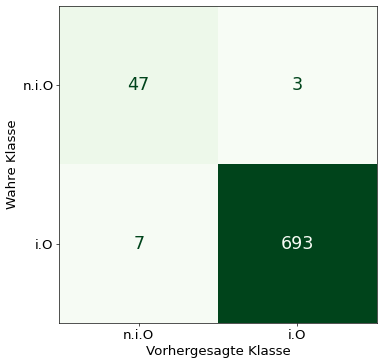

In [79]:
ch.plot_calc_cm(y_test, y_pred, class_name=["n.i.O","i.O"], dpi=60, fontsize=16)

# 4. Saving results

In [80]:
params = {"kernel": ['rbf', 'sigmoid'],
            "coef0": [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
            "gamma": ['scale','auto', 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9],
            "nu": [0.1, 0.3, 0.5]}
params

{'kernel': ['rbf', 'sigmoid'],
 'coef0': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
 'gamma': ['scale', 'auto', 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9],
 'nu': [0.1, 0.3, 0.5]}

In [82]:
best_model.get_params()

{'cache_size': 200,
 'coef0': 0.1,
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [84]:
res = ch.collect_results_occ(y_test, y_pred, algorithm="oc_svm_tsfresh", params=params, 
                          best_param=best_model.get_params(), cm=confusion_matrix(y_test, y_pred).tolist())
res

{'algorithm': 'oc_svm_tsfresh',
 'params': {'kernel': ['rbf', 'sigmoid'],
  'coef0': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
  'gamma': ['scale', 'auto', 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9],
  'nu': [0.1, 0.3, 0.5]},
 'best_param': {'cache_size': 200,
  'coef0': 0.1,
  'degree': 3,
  'gamma': 'scale',
  'kernel': 'rbf',
  'max_iter': -1,
  'nu': 0.1,
  'shrinking': True,
  'tol': 0.001,
  'verbose': False},
 'cm': [[47, 3], [7, 693]],
 'rec': 0.99,
 'pre': 0.9956896551724138,
 'f1': 0.992836676217765,
 'acc': 0.9866666666666667}

In [85]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "oc_svm_tsfresh", 
                     hyperopt_result = res)

existing file occ_hyperopt_results_v2.4.1.json opened and results of oc_svm_tsfresh saved.
